In [1]:
import sys
sys.path.append('../src')

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [3]:
from gait.config import pd
from gait.utils import get_data_by_overlap_percent, split_test_train_by_subjects
from gait.training import train_model
from gait.evalution import save_history, save_test_history, save_accuracy_loss_figure, save_confusion_matrix_figure, compute_validations_predictions

UNIQUE>>>>>>> ['Olw8IwOqovs7SnBd', 'Oc8ls6zG1SNL7oDg', '0uxxjc38wrVfNfTb', '8lwH63TSv952hp9k', 'DuVldwfMslADzcty', 'tfmhKTNXv0iniiJT']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 9, 8)         656       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 3, 8)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 42, 3, 8)         32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 3, 32)         1056      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 3, 32)      

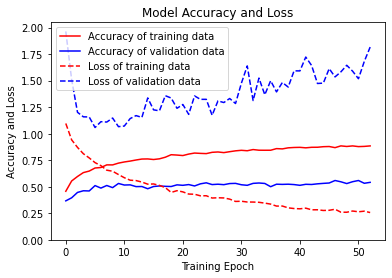

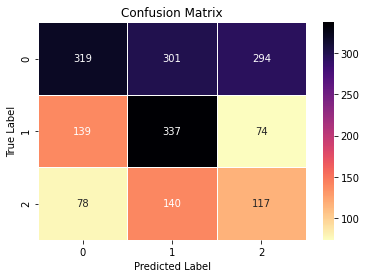

UNIQUE>>>>>>> ['tfmhKTNXv0iniiJT', '8lwH63TSv952hp9k', 'DuVldwfMslADzcty', '0uxxjc38wrVfNfTb', 'Oc8ls6zG1SNL7oDg', 'Olw8IwOqovs7SnBd']
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 9, 8)         656       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 42, 3, 8)         0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 42, 3, 8)         32        
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 3, 32)         1056      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 3, 32)    

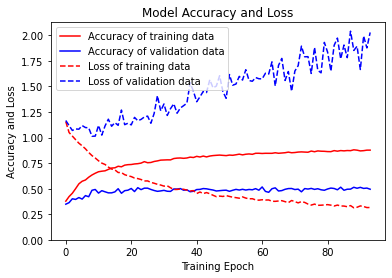

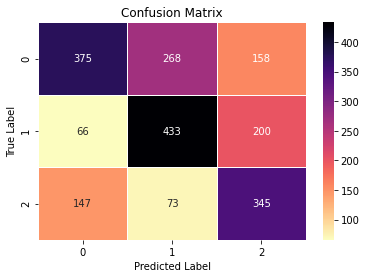

UNIQUE>>>>>>> ['0uxxjc38wrVfNfTb', '8lwH63TSv952hp9k', 'Oc8ls6zG1SNL7oDg', 'tfmhKTNXv0iniiJT', 'DuVldwfMslADzcty', 'Olw8IwOqovs7SnBd']
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 9, 8)         656       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 42, 3, 8)         0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 42, 3, 8)         32        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 3, 32)         1056      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 3, 32)    

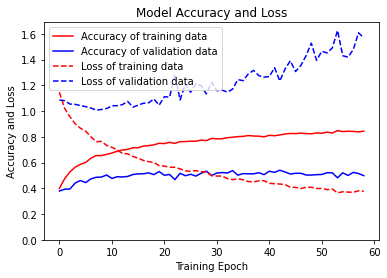

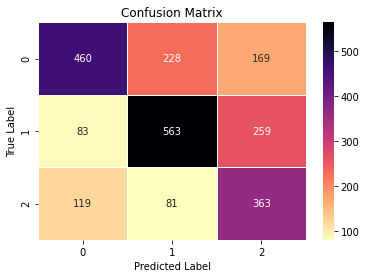

UNIQUE>>>>>>> ['8lwH63TSv952hp9k', 'Olw8IwOqovs7SnBd', 'DuVldwfMslADzcty', 'tfmhKTNXv0iniiJT', '0uxxjc38wrVfNfTb', 'Oc8ls6zG1SNL7oDg']
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 9, 8)         656       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 42, 3, 8)         0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 42, 3, 8)         32        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 42, 3, 32)         1056      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 3, 32)    

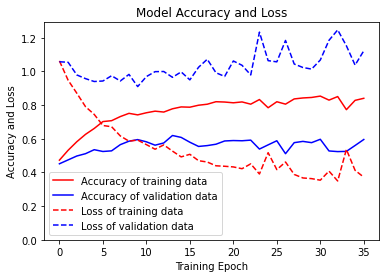

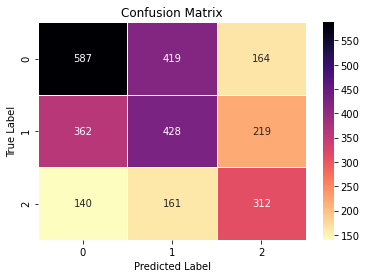

UNIQUE>>>>>>> ['tfmhKTNXv0iniiJT', 'Olw8IwOqovs7SnBd', 'DuVldwfMslADzcty', '8lwH63TSv952hp9k', 'Oc8ls6zG1SNL7oDg', '0uxxjc38wrVfNfTb']
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 9, 8)         656       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 42, 3, 8)         0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 42, 3, 8)         32        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 3, 32)         1056      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 3, 32)    

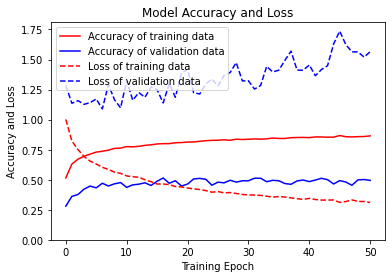

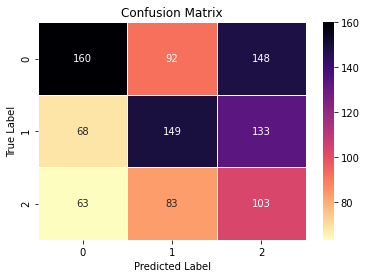

UNIQUE>>>>>>> ['8lwH63TSv952hp9k', '0uxxjc38wrVfNfTb', 'Olw8IwOqovs7SnBd', 'Oc8ls6zG1SNL7oDg', 'DuVldwfMslADzcty', 'tfmhKTNXv0iniiJT']
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 9, 8)         656       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 42, 3, 8)         0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 42, 3, 8)         32        
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 42, 3, 32)         1056      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 3, 32)    

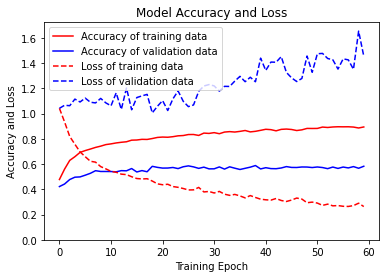

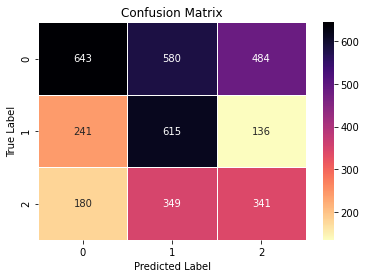

UNIQUE>>>>>>> ['0uxxjc38wrVfNfTb', 'tfmhKTNXv0iniiJT', 'Olw8IwOqovs7SnBd', '8lwH63TSv952hp9k', 'DuVldwfMslADzcty', 'Oc8ls6zG1SNL7oDg']
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 9, 8)         656       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 42, 3, 8)         0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 42, 3, 8)         32        
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 42, 3, 32)         1056      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 3, 32)    

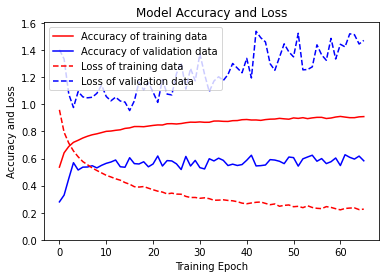

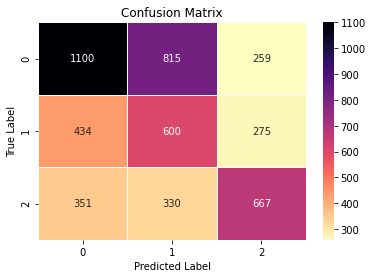

UNIQUE>>>>>>> ['0uxxjc38wrVfNfTb', 'Oc8ls6zG1SNL7oDg', 'Olw8IwOqovs7SnBd', 'tfmhKTNXv0iniiJT', '8lwH63TSv952hp9k', 'DuVldwfMslADzcty']
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 9, 8)         656       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 42, 3, 8)         0         
 g2D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 42, 3, 8)         32        
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 42, 3, 32)         1056      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 3, 32)    

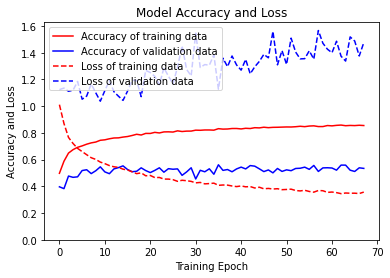

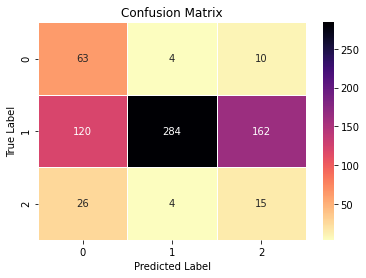

UNIQUE>>>>>>> ['DuVldwfMslADzcty', '0uxxjc38wrVfNfTb', 'Oc8ls6zG1SNL7oDg', 'tfmhKTNXv0iniiJT', '8lwH63TSv952hp9k', 'Olw8IwOqovs7SnBd']
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 128, 9, 8)         656       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 42, 3, 8)         0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 42, 3, 8)         32        
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 42, 3, 32)         1056      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 3, 32)    

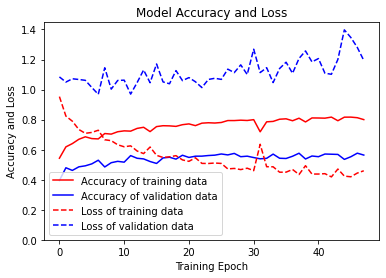

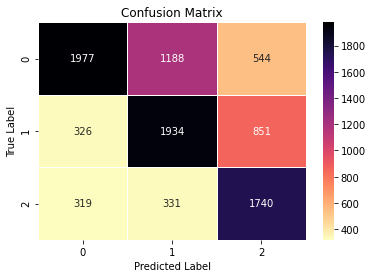

UNIQUE>>>>>>> ['8lwH63TSv952hp9k', 'tfmhKTNXv0iniiJT', 'Olw8IwOqovs7SnBd', '0uxxjc38wrVfNfTb', 'Oc8ls6zG1SNL7oDg', 'DuVldwfMslADzcty']
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 9, 8)         656       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 42, 3, 8)         0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 42, 3, 8)         32        
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 42, 3, 32)         1056      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 3, 32)    

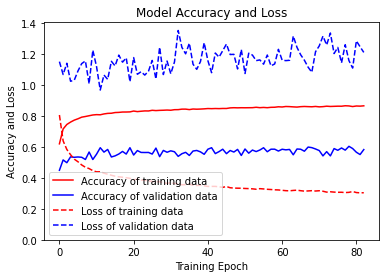

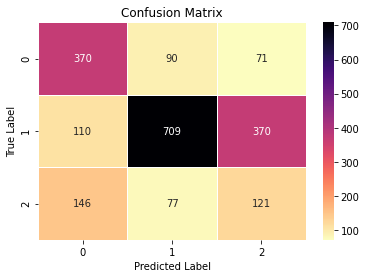

In [4]:
overlapPercents = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

for OVERLAP_PERCENT in overlapPercents:
    X, y, subjects = get_data_by_overlap_percent(OVERLAP_PERCENT)
    exclude_subjects = ['d0g4P7NNnPGEJ6om'];
    indexes = np.where(subjects == exclude_subjects)

    X = np.delete(X, indexes[0], axis=0)
    y = np.delete(y, indexes[0], axis=0)
    subjects = np.delete(subjects, indexes[0], axis=0)

    X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
        X, y, subjects, train_percent=0.9)
    model, history, evaluation_history = train_model(X_train, y_train, X_test, y_test, overlap_percent=OVERLAP_PERCENT, epochs=100, variant="dsconvcnn")
    save_history(history, OVERLAP_PERCENT)
    save_test_history(evaluation_history, OVERLAP_PERCENT)
    save_accuracy_loss_figure(history, OVERLAP_PERCENT)
    validations, predictions = compute_validations_predictions(
        model, X_test, y_test)
    save_confusion_matrix_figure(validations, predictions, OVERLAP_PERCENT, sns)